In [1]:
import os
import geopandas as gpd
import ee, eemont, geemap
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.plot import show
import rioxarray as rxr
import xarray as xr
from sklearn import cluster
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from datetime import datetime, timedelta

from  py00_model_fucntion import run_full_model

Map = geemap.Map()

In [2]:
# Data sourced from https://catalogue.data.wa.gov.au/dataset/dbca-fire-history - login required to download shapefile

try: 
    fire_history = gpd.read_file('poly_simplified/poly_simplified_output.shp')
except:
    fire_bulk = gpd.read_file('DBCAFireHistoryDBCA_060.zip')
    fire_history = (fire_bulk[(fire_bulk.fih_year1 > 2013) &
                              (fire_bulk['fih_hectar'] > fire_bulk['fih_hectar'].quantile(.90)) &
                              (fire_bulk['fih_fire_t'] == 'WF')
                              ]
    )
    fire_history.to_file('sample_poly/sample_poly.shp')
    fire_history = gpd.read_file('poly_simplified/poly_simplified_output.shp')

fire_test = fire_history[fire_history['fih_name'] == 'Murray Road'].to_crs('EPSG:4326')


In [3]:
run_full_model(fire_test)

Generating URL ...
Please wait ...
Data downloaded to c:\Users\micha\spatial-work\repos\bushfire-modeling-gee\imagery\pre_test.tif
Generating URL ...
Please wait ...
Data downloaded to c:\Users\micha\spatial-work\repos\bushfire-modeling-gee\imagery\post_test.tif
Generating URL ...
Please wait ...
Data downloaded to c:\Users\micha\spatial-work\repos\bushfire-modeling-gee\imagery\ndvi_test.tif
Generating URL ...
Please wait ...
Data downloaded to c:\Users\micha\spatial-work\repos\bushfire-modeling-gee\imagery\post_ndvi_test.tif


[          dnbr  dnbr_class  spatial_ref  ndvi_120  spatial_ref   ndvi_14  \
 0    -0.000061           2            0 -1.000000            0 -1.000000   
 1     0.000061           2            0 -1.000000            0 -0.999939   
 2    -0.041667           2            0 -1.000000            0 -1.000000   
 3     0.000061           2            0 -1.000000            0 -0.999939   
 4     0.000000           2            0 -1.000000            0 -1.000000   
 ...        ...         ...          ...       ...          ...       ...   
 9172  0.045508           2            0  0.650434            0  0.241669   
 9173  0.066320           2            0  0.646732            0  0.227090   
 9174  0.050807           2            0  0.697807            0  0.229665   
 9175  0.081090           2            0  0.767496            0  0.210492   
 9176  0.107491           3            0  0.718862            0  0.229206   
 
          dndvi fire_name  
 0     0.000000       068  
 1     0.000061   

In [4]:
pre_path = "imagery/pre_test.tif"

# Open and read in the MODIS file
# Note that rxr is the alias for rioxarray
raster_pre = rxr.open_rasterio(pre_path)

pre_nbr = (raster_pre[0] - raster_pre[1]) / (raster_pre[0] + raster_pre[1])

rxr.open_rasterio(pre_path).close()

post_path = "imagery/post_test.tif"

# Open and read in the MODIS file
# Note that rxr is the alias for rioxarray
raster_post = rxr.open_rasterio(post_path)

post_nbr = (raster_post[0] - raster_post[1]) / (raster_post[0] + raster_post[1])

rxr.open_rasterio(post_path).close()

dnbr = (pre_nbr.values - post_nbr.values)

dnbr_xr = xr.DataArray(dnbr, 
                       coords = [post_nbr.y.values, 
                       post_nbr.x.values], 
                       dims = ['y', 'x'])

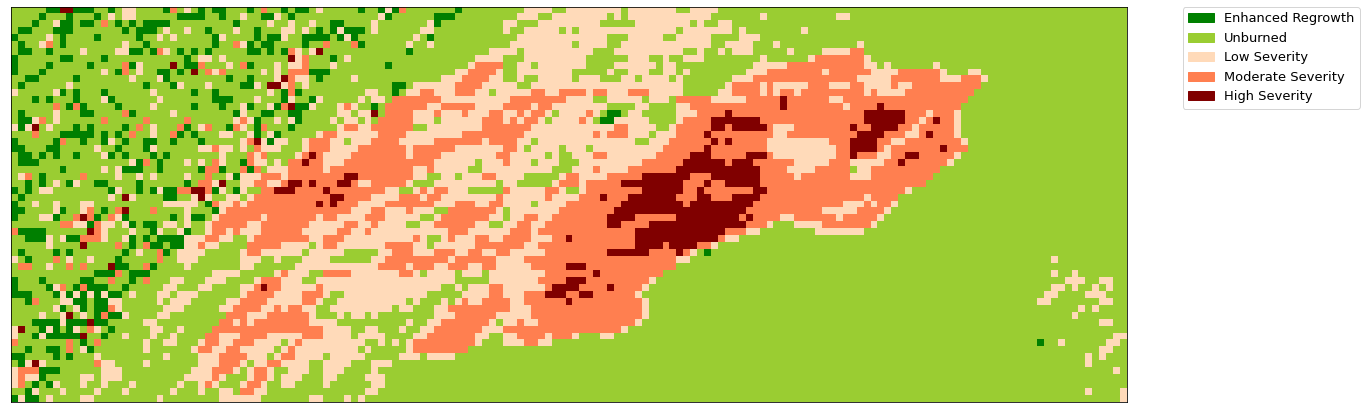

In [5]:
dnbr_cat_names = ["Enhanced Regrowth",
                  "Unburned",
                  "Low Severity",
                  "Moderate Severity",
                  "High Severity"]

nbr_colors = ["g",
              "yellowgreen",
              "peachpuff",
              "coral",
              "maroon"]

nbr_cmap = colors.ListedColormap(nbr_colors)

# Define dNBR classification bins
dnbr_class_bins = [-np.inf, -.1, .1, .27, .66, np.inf]

dnbr_class = xr.apply_ufunc(np.digitize,
                            dnbr_xr,
                            dnbr_class_bins)

dnbr_class

fig, ax = plt.subplots(figsize=(20, 10))

classes = np.unique(dnbr_class)
classes = classes.tolist()[:5]

ep.plot_bands(dnbr_class,
              cmap = nbr_cmap,
              vmin = 1,
              vmax = 5,
              cbar=False,
              scale=False,
              ax = ax)

ep.draw_legend(im_ax=ax.get_images()[0],
               classes=classes,
               titles = dnbr_cat_names)

plt.show()

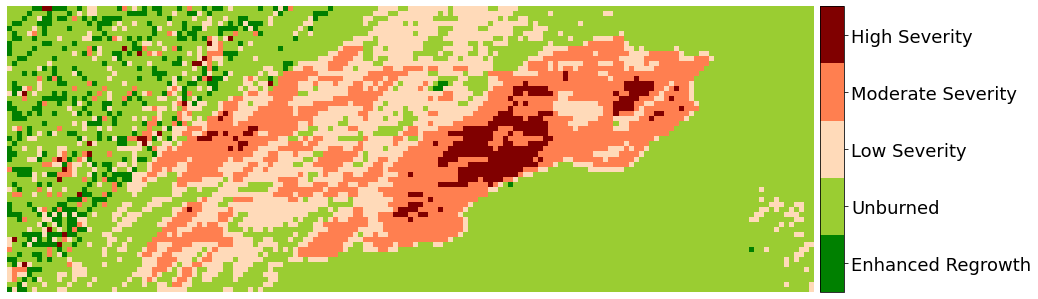

In [6]:
# Grab raster unique values (classes)
values = np.unique(dnbr_class).tolist()

# Add another index value because for n categories
# you need n+1 values to create bins
values = [0] + values

# Make a color map of fixed colors
nbr_colors = ["g", "yellowgreen", "peachpuff", "coral", "maroon"]
nbr_cmap = colors.ListedColormap(nbr_colors)

# But the goal is the identify the MIDDLE point
# of each bin to create a centered tick
bounds = [((a + b) / 2) for a, b in zip(values[:-1], values[1::1])] + [5.5]

# Define normalization
norm = colors.BoundaryNorm(bounds, nbr_cmap.N)

# Plot the data
fig, ax = plt.subplots(figsize=(15, 10))

ep.plot_bands(dnbr_class,
              ax=ax,
              cmap=nbr_cmap,
              norm=norm,
              cbar=False)

cbar = ep.colorbar(ax.get_images()[0])

cbar.set_ticks([np.unique(dnbr_class)])
cbar.set_ticklabels(dnbr_cat_names)
cbar.ax.set_yticklabels(dnbr_cat_names, fontsize=18)

# Turn off ticks
ax.set_axis_off()
plt.show()

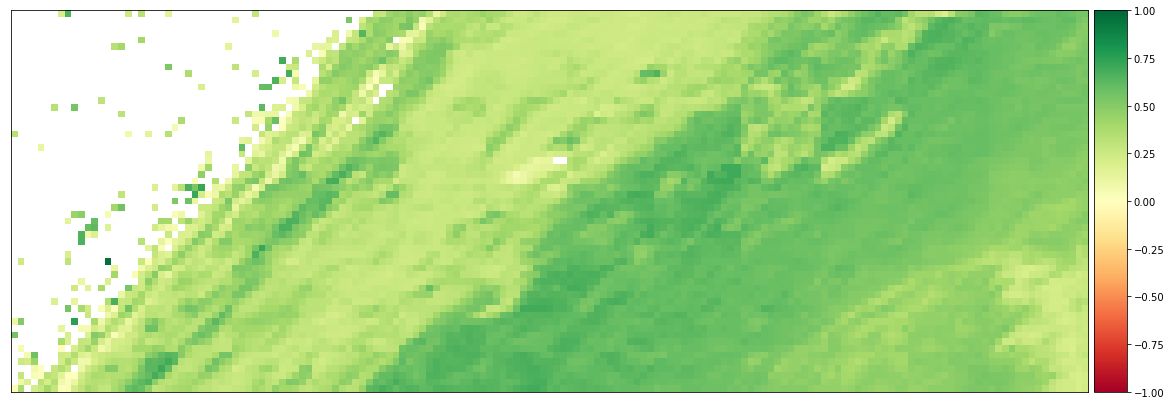

In [7]:
post_ndvi_path = "imagery/post_ndvi_test.tif"

# Open and read in the MODIS file
# Note that rxr is the alias for rioxarray
raster_post_ndvi = rxr.open_rasterio(post_ndvi_path)

post_ndvi = (raster_post_ndvi[1] - raster_post_ndvi[0]) / (raster_post_ndvi[0] + raster_post_ndvi[1]) 

rxr.open_rasterio(post_ndvi_path).close()

ndvi_xr = xr.DataArray(post_ndvi, 
                       coords = [post_ndvi.y.values, post_ndvi.x.values], 
                       dims = ['y', 'x']).where(post_ndvi > 0)

fig, ax = plt.subplots(figsize=(20, 10))

ep.plot_bands(ndvi_xr,
              cmap = 'RdYlGn',
              vmin = -1,
              vmax = 1,
              cbar = True,
              scale = False,
              ax = ax)

plt.show()

In [8]:
pre_path = "imagery/pre_test.tif"
raster_pre = rxr.open_rasterio(pre_path)
pre_nbr = (raster_pre[0] - raster_pre[1]) / (raster_pre[0] + raster_pre[1])

post_path = "imagery/post_test.tif"
raster_post = rxr.open_rasterio(post_path)
post_nbr = (raster_post[0] - raster_post[1]) / (raster_post[0] + raster_post[1])

ndvi_path = "imagery/ndvi_test.tif"
raster_ndvi = rxr.open_rasterio(ndvi_path)
ndvi = (raster_ndvi[1] - raster_ndvi[0]) / (raster_ndvi[1] + raster_ndvi[0])

post_ndvi_path = "imagery/post_ndvi_test.tif"
raster_post_ndvi = rxr.open_rasterio(post_ndvi_path)
post_ndvi = (raster_post_ndvi[1] - raster_post_ndvi[0]) / (raster_post_ndvi[1] + raster_post_ndvi[0])

dnbr = (pre_nbr.values - post_nbr.values)
dndvi = (post_ndvi.values - ndvi.values)

dnbr_xr = xr.DataArray(dnbr, 
                       coords = [post_nbr.y.values, 
                       post_nbr.x.values], 
                       dims = ['y', 'x']).where(dnbr > -0.2)

dndvi_xr = xr.DataArray(dndvi, 
                        coords = [post_ndvi.y.values, 
                        post_ndvi.x.values], 
                        dims = ['y', 'x']).where((ndvi < 1) & (ndvi > -0.9))

ndvi_xr = xr.DataArray(ndvi, 
                       coords = [ndvi.y.values, 
                       ndvi.x.values], 
                       dims = ['y', 'x']).where(post_ndvi > -0.5)
p_ndvi_xr = xr.DataArray(post_ndvi, 
                         coords = [post_ndvi.y.values, 
                         post_ndvi.x.values], 
                         dims = ['y', 'x']).where(post_ndvi > -0.5)

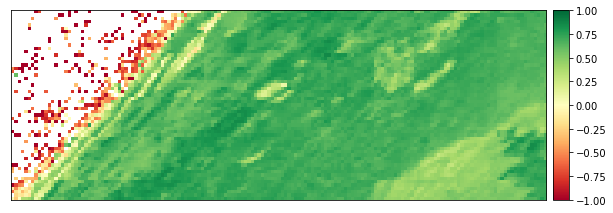

In [9]:
fire_test2 = fire_history[fire_history['fih_name'] == 'Murray Road'].to_crs(ndvi_xr.rio.crs)

fig, ax = plt.subplots(figsize=(10, 5))

ep.plot_bands(ndvi_xr,
              cmap = 'RdYlGn',
              vmin = -1,
              vmax = 1,
              cbar = True,
              scale = False,
              ax = ax)

plt.show()

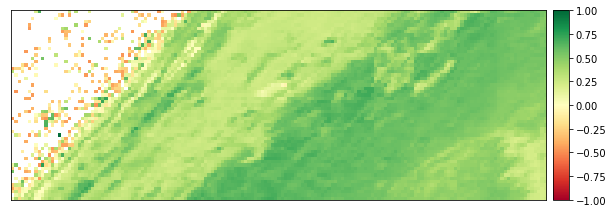

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))

ep.plot_bands(p_ndvi_xr,
              cmap = 'RdYlGn',
              vmin = -1,
              vmax = 1,
              cbar = True,
              scale = False,
              ax = ax)

plt.show()

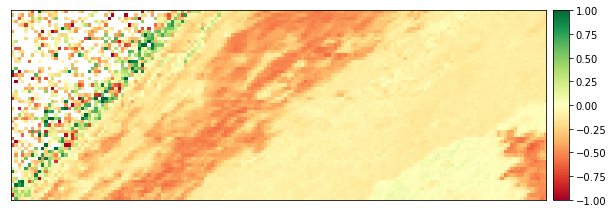

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))

ep.plot_bands(dndvi_xr,
              cmap = 'RdYlGn',
              vmin = -1,
              vmax = 1,
              cbar = True,
              scale = False,
              ax = ax)

plt.show()

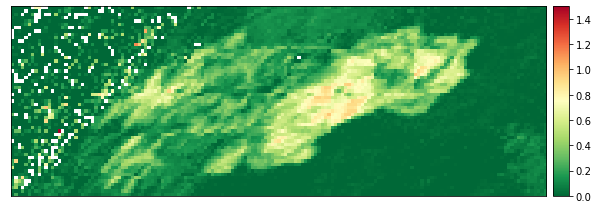

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

ep.plot_bands(dnbr_xr,
              cmap = 'RdYlGn_r',
              cbar = True,
              vmin = 0,
              vmax = 1.5,
              scale = False,
              ax = ax)

plt.show()